# T-GCN

+ from : https://ieeexplore.ieee.org/document/8809901
+ Github: https://github.com/lehaifeng/T-GCN
+ clone2: `(G) D::~external/T-GCN` 
+ dataset: Los & SZ traffic spped, in `clone2` & `./data`

# My Implement

+ use PyG rather than man-made GraphConv
+ implement all of the 3 models: GCN, GRU, TGCN, as an exercise

## GCN

### Algorithm

+ 先理一下思路emmm
+ 这里就是简单的卷积, 然后就单隐藏层...
+ 超参数的话, batch_size 64, hidden_dim 100, input_dim 12
+ input_dim是dataloader里的seq_len, 12, 对应pre_len: 3, 我的理解就是用12个时刻的数据去预测后面3个时刻的结果
+ 有个问题, 单GCN怎么处理这12个时刻的图数据? 当成一个node的12个properties? 好像还真是, 毕竟用seq_len作为input_dim了都...嗯..那我就这么搞!


### issues

+ 不用pytorch_lightning因为以后估计在sw上用不了...
+ 不是, 为啥论文里说`each row represents one road`啊, 我看数据明明row是一个时间...
+ 我得做个pyG可用的数据集, 看看之前拿到的教程里的...
   * 靠, 原来一个Data只得到一个sample...还得用个list传进DataLoader里去, ok..
+ 为啥他的代码里有个weight没bias的?
   * 原来是AXW里的W, 他就是没有bias...还没到linear层
   * 那应该在pyG的conv里包含了不用我手写吧?
      - 哎对
+ 有一个问题啊, 对于一个GCNConv, 按理说我应该传入一个二位数组(n_nodes, n_properties), 但是batchsize?
   * 我看他T-GCN是手动处理这个逻辑的...就是把n_batchsize和n_properties成起来了, 可以理解成, 嗯, 一个图, 但是属性变多了
   * 但是pyG我发现他好像可以直接传3维数组进去?
   * 而且我check了一下, 算的和单个2维传进去算的是一样的呢, 啊?
   * 问GPT也没用, 他说expected 2-d的呢?...
   * 我觉得我得用pycharm去debug mode看看, md他这个源代码直接看看不明白, 用了hook啥的函数变量去调用, md根本找不到在哪
   * 又问了GPT半天, 回答我说是对于temporal的, PyG自动回一个一个的去计算, ok, 和我想的一致
   * 但是是这样婶儿的, 3维的传进去, 没问题, 但是如果是2维的但是拼接的话, **那就有问题!!**
   * 他就只有第一个graph参与了计算实际上, 除非我把edge_index也给做进去
   * ok, 然后我坐进了ai_rdee里去..嗯...有点强行哈哈, 之后再考虑修改吧

***
***
***

In [2]:
import numpy as np
import pandas as pd

import torch
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


import matplotlib.pyplot as plt

import sys

sys.path.append('../../ai.rdee')

# import ai_rdee

In [3]:
from torch.utils.data import random_split


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# df_adj = pd.read_csv('data/sz_adj.csv', index_col=None, header = None)

# A = df_adj.values
# A.shape

# eis = np.argwhere(A == 1).T

# teis = torch.tensor(eis).to(device)

In [5]:
# import torch
from torch_geometric.data import InMemoryDataset


class TGCN_dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data/sz_adj.csv', 'data/sz_speed.csv']

    @property
    def processed_file_names(self):
        return ['data_sz.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass
        
    def process(self):
        # Read data into huge `Data` list.
        fn_adj, fn_spd = self.raw_file_names
        df_spd = pd.read_csv(fn_spd)
        S = df_spd.values.T
        df_adj = pd.read_csv(fn_adj, index_col=None, header = None)

        A = df_adj.values
        A.shape

        eis = torch.tensor(np.argwhere(A == 1).T)
        S = torch.Tensor(S)
        data_list = []
        for i in range(S.shape[1]-14):
            data = Data(x=S[:,i:i+12], y=S[:,i+12:i+15], edge_index=eis)
            data_list.append(data)
        
        
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [6]:
szd = TGCN_dataset('./data')

In [9]:
szd.slices

defaultdict(dict,
            {'x': tensor([     0,    156,    312,  ..., 461760, 461916, 462072]),
             'edge_index': tensor([      0,     532,    1064,  ..., 1574720, 1575252, 1575784]),
             'y': tensor([     0,    156,    312,  ..., 461760, 461916, 462072])})

In [10]:
szd_learn, szd_test = random_split(szd, [0.8, 0.2])

In [39]:
dlr = DataLoader(szd[[1,2,3,4]], batch_size=2)

In [40]:
for data in dlr:
    print(data)

DataBatch(x=[312, 12], edge_index=[2, 1064], y=[312, 3], batch=[312], ptr=[3])
DataBatch(x=[312, 12], edge_index=[2, 1064], y=[312, 3], batch=[312], ptr=[3])


In [37]:
a = szd[[1,2]]

In [38]:
a

TGCN_dataset(2)

In [27]:
szd.data

D:\XAPP\miniconda3\envs\ai\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[462072, 12], edge_index=[2, 1575784], y=[462072, 3])

In [29]:
2962 * 156

462072

In [31]:
szd.slices

defaultdict(dict,
            {'x': tensor([     0,    156,    312,  ..., 461760, 461916, 462072]),
             'edge_index': tensor([      0,     532,    1064,  ..., 1574720, 1575252, 1575784]),
             'y': tensor([     0,    156,    312,  ..., 461760, 461916, 462072])})

In [35]:
szd.slices['edge_index'].size()

torch.Size([2963])

In [22]:
szd[1]

Data(x=[156, 12], edge_index=[2, 532], y=[156, 3])

In [11]:
len(szd)

2962

In [12]:
test_ratio = 0.2
test_len = int(test_ratio * len(szd))

In [13]:
learn_len = len(szd) - test_len

In [14]:
szd_learn, szd_test = random_split(szd, [learn_len, test_len])

In [15]:
# dlr_learn = DataLoader(szd_train, batch_size=64, shuffle=True)
# dlr_test = DataLoader(szd_valid, batch_size=592)

In [16]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(9981)
        self.conv1 = GCNConv(12, 20) # 只需定义好输入特征和输出特征即可
        self.regressor = Linear(20, 3)

    def forward(self, x, edge_index):
        # x : nBatch x nnodes x 12
        
        
        h = self.conv1(x, edge_index) # 输入特征与邻接矩阵（注意格式，上面那种）
        h = h.tanh()
        
        # 分类层
        out = self.regressor(h)

        return out

In [17]:
model = GCN()

model.to(device)

# model.double()

criterion = nn.MSELoss()
optm = torch.optim.Adam(model.parameters())
esp = ai_rdee.AiTools.EarlyStopping(200)


In [21]:
rgGNN = ai_rdee.Regression.GNNRegression(model, criterion, optm, esp, 2000)

In [22]:
rgGNN.train(szd_learn, batch_size=64, verbose_nEpoch=20)

[  20/2000] train_loss: 117.35287, valid_loss: 113.85295, min_loss : 115.52928829193115, @2023/09/21 16:21:57
[  40/2000] train_loss: 88.82689, valid_loss: 88.14357, min_loss : 88.17438793182373, @2023/09/21 16:22:02
[  60/2000] train_loss: 76.82955, valid_loss: 76.20303, min_loss : 75.20321559906006, @2023/09/21 16:22:07
[  80/2000] train_loss: 69.06510, valid_loss: 69.57649, min_loss : 68.83186960220337, @2023/09/21 16:22:12
[ 100/2000] train_loss: 64.12400, valid_loss: 63.61861, min_loss : 63.60034513473511, @2023/09/21 16:22:17
[ 120/2000] train_loss: 60.40593, valid_loss: 61.02468, min_loss : 60.524330615997314, @2023/09/21 16:22:22
[ 140/2000] train_loss: 57.94391, valid_loss: 58.38985, min_loss : 57.66831302642822, @2023/09/21 16:22:27
[ 160/2000] train_loss: 56.37687, valid_loss: 56.05971, min_loss : 55.868563652038574, @2023/09/21 16:22:32
[ 180/2000] train_loss: 54.97384, valid_loss: 55.71351, min_loss : 54.66372299194336, @2023/09/21 16:22:37
[ 200/2000] train_loss: 54.49748

In [23]:
rgp = rgGNN.perf

In [25]:
rgp.valid.show()

target : tg1
size   = 221832.000
r      =      0.816
r2     =      0.666
rmse   =      7.310
nRMSE  =      0.578
MSE    =     53.436


In [38]:
szd._data

Data(x=[462072, 12], edge_index=[2, 1575784], y=[462072, 3])

In [40]:
dlr_test = DataLoader(szd_test, batch_size = len(szd_test))

In [41]:
dbh = next(iter(dlr_test))

In [42]:
dbh.to(device)

DataBatch(x=[92352, 12], edge_index=[2, 314944], y=[92352, 3], batch=[92352], ptr=[593])

In [43]:
y_test_fit = rgGNN.predict(dbh.x, dbh.edge_index)

In [44]:
y_test = dbh.y

In [45]:
y_test_fit

tensor([[30.2115, 30.2021, 30.1633],
        [14.4415, 14.3604, 14.3389],
        [19.4918, 19.4273, 19.3945],
        ...,
        [12.8618, 12.9470, 12.9237],
        [16.1207, 16.0147, 15.9994],
        [18.2042, 18.1449, 18.1107]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [52]:
y_test_fit.shape

torch.Size([92352, 3])

In [47]:
rgp.test(y_test_fit.detach().cpu().view(-1), y_test.detach().cpu().view(-1))

In [49]:
rgp.test.show()

target : tg1
size   = 277056.000
r      =      0.815
r2     =      0.663
rmse   =      7.465
nRMSE  =      0.580
MSE    =     55.734


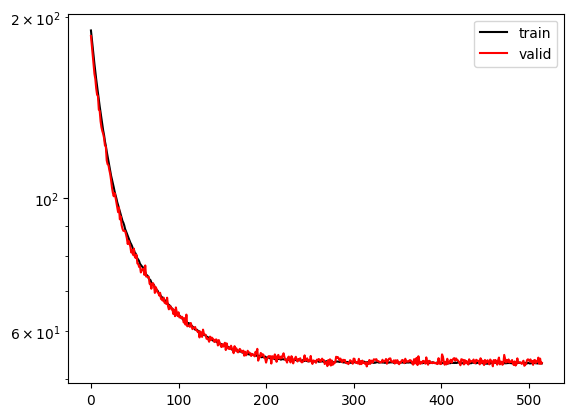

In [53]:
rgp.plot_losses()